In [40]:
import pandas as pd
import numpy as np
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [12]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Sruthi
[nltk_data]     Srikanth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Sruthi
[nltk_data]     Srikanth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to C:\Users\Sruthi
[nltk_data]     Srikanth\AppData\Roaming\nltk_data...


True

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# **1. Load Dataset**
df = pd.read_csv('cleaned_news_data.csv')

In [4]:
# Handle missing values
df['title'] = df['title'].fillna('')
df['content'] = df['content'].fillna('')

In [41]:
# Combine title and content with priority weighting
def prioritize_title(row, weight=5):
    weighted_title = (row['title'] + '. ') * weight
    return weighted_title + row['content']

df['combined_text'] = df.apply(prioritize_title, axis=1)

C:\Users\Sruthi Srikanth\AppData\Local\Temp\ipykernel_12528\1161952873.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['combined_text'] = df.apply(prioritize_title, axis=1)


In [6]:
# **2. Load Model and Prepare SWOT Keywords**
model = SentenceTransformer('all-MiniLM-L6-v2')

C:\Users\Anaconda\envs\deepLearning\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\Anaconda\envs\deepLearning\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [36]:
# Define SWOT keywords
swot_keywords = {
    "Strengths": [
        "market leader", "customer satisfaction", "brand loyalty", "strong revenue", "high profit margin",
        "unique selling point", "competitive advantage", "high brand equity", "quality products",
        "positive brand perception", "advantage", "strong", "leader", "success", "achieved", "profit", "growth", "top", "excellent", "dominant", "innovative"
    ],
    "Weaknesses": [
        "lawsuit", "product recall", "negative feedback", "decline in sales", "loss of market share",
        "supply chain issues", "high operational costs", "reduced profitability", "brand damage",
        "scandal", "controversy", "data breach", "security vulnerability","weak", "problem", "issue", "challenge", "poor", "lack", "decline", "failure", "flaw", "disadvantage", "loss"
    ],
    "Opportunities": [
        "growth potential", "new market", "investment", "technological innovation", "expansion opportunity",
        "strategic partnership", "emerging markets", "increased demand", "product diversification",
        "positive industry trend", "new product launch", "acquisition", "merger", "opportunity", "growth", "potential", "market", "trend", "future", "expansion", "upside", "demand", "prospect"
    ],
    "Threats": [
        "economic downturn", "competition", "regulation", "supply chain issue", "currency fluctuation",
        "market saturation", "new entrant", "substitute product", "changing consumer preferences",
        "recession", "natural disaster", "political instability", "cyber attack", "litigation risk", "threat", "competition", "risk", "danger", "loss", "attack", "barrier", "downside", "obstacle", "challenge", "limitation"
    ]
}

In [37]:
# Precompute SWOT embeddings
print("Generating embeddings for SWOT keywords...")
swot_embeddings = {category: model.encode(words) for category, words in swot_keywords.items()}


Generating embeddings for SWOT keywords...


In [47]:
def tokenize_sentences(content):
    """
    Tokenize content into sentences using punctuation and specific conjunctions
    without using lookbehind assertions.
    """
    if not content.strip():
        return []
    # Match sentence-ending punctuation or specific words and split
    sentences = re.split(r'[.!?;]|(?:\b(?:However|But|In contrast|Thus)\b)', content)
    return [sentence.strip() for sentence in sentences if sentence.strip()]

In [16]:
import spacy

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

def tokenize_sentences_spacy(content):
    doc = nlp(content)
    return [sent.text for sent in doc.sents]

In [21]:
import re

def tokenize_sentences(content):
    """
    Tokenize content into sentences using a simple regex-based approach.
    """
    if not content.strip():  # Check for empty content
        return []
    # Split by sentence-ending punctuation and remove empty strings
    sentences = re.split(r'[.!?]', content)
    return [sentence.strip() for sentence in sentences if sentence.strip()]

def batch_categorize(content, combined_text):
    # Tokenize sentences using the new tokenize_sentences function
    sentences = tokenize_sentences(content)
    if not sentences:  # Skip processing if no sentences are found
        return ["Null"]

    # Generate embeddings for sentences
    sentence_embeddings = model.encode(sentences, batch_size=16, show_progress_bar=False)
    if len(sentence_embeddings) == 0:  # Ensure embeddings are valid
        return ["Null"]

    # Generate embedding for combined text
    combined_embedding = model.encode(combined_text, show_progress_bar=False)

    # Store categories
    sentence_categories = set()
    
    # Batch process SWOT similarity for sentences
    for category, embeddings in swot_embeddings.items():
        sim_scores = cosine_similarity(sentence_embeddings, embeddings).max(axis=1)
        if np.any(sim_scores > 0.3):  # Threshold for sentence similarity
            sentence_categories.add(category)
    
    # Process combined text for overall categorization
    for category, embeddings in swot_embeddings.items():
        sim_scores = cosine_similarity([combined_embedding], embeddings).flatten()
        if max(sim_scores) > 0.4:  # Threshold for combined text
            sentence_categories.add(category)
    
    # Add Null category if no matches
    if not sentence_categories:
        sentence_categories.add("Null")
    
    return list(sentence_categories)

In [22]:
# Apply categorization in a vectorized manner
print("Categorizing articles...")
df['categories'] = df.apply(lambda row: batch_categorize(row['content'], row['combined_text']), axis=1)

Categorizing articles...


In [23]:
# **4. Count Categories**
print("Counting categories...")
all_categories = [category for categories in df['categories'] for category in categories]
category_counts = pd.Series(all_categories).value_counts()

print("\nCategory counts:")
print(category_counts)

Counting categories...

Category counts:
Null             143291
Weaknesses        18866
Threats           14519
Opportunities      9942
Strengths          8744
Name: count, dtype: int64


In [24]:
# **5. Save Results**
df.to_csv('optimized_categorized_dataset.csv', index=False)

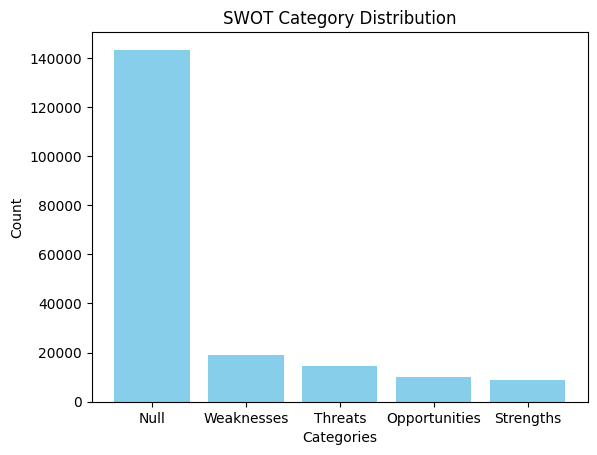

In [25]:
# **6. Visualize the Results**
import matplotlib.pyplot as plt
plt.bar(category_counts.index, category_counts.values, color='skyblue')
plt.title('SWOT Category Distribution')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

In [48]:
# **4. Recategorization Logic for Null Entries**
def recategorize_nulls(df, model, swot_embeddings, sentence_threshold=0.15, combined_threshold=0.25):
    def process_null_row(content, combined_text):
        # Tokenize sentences
        sentences = tokenize_sentences(content)
        if not sentences:
            return ["Null"]

        # Generate embeddings for sentences
        sentence_embeddings = model.encode(sentences, batch_size=16, show_progress_bar=False)
        if len(sentence_embeddings) == 0:
            return ["Null"]

        # Generate embedding for combined text
        combined_embedding = model.encode(combined_text, show_progress_bar=False)

        # Store categories
        sentence_categories = set()
        
        # Batch process SWOT similarity for sentences
        for category, embeddings in swot_embeddings.items():
            sim_scores = cosine_similarity(sentence_embeddings, embeddings).max(axis=1)
            if np.any(sim_scores > sentence_threshold):  # Lower threshold for sentences
                sentence_categories.add(category)
        
        # Process combined text for overall categorization
        for category, embeddings in swot_embeddings.items():
            sim_scores = cosine_similarity([combined_embedding], embeddings).flatten()
            if max(sim_scores) > combined_threshold:  # Lower threshold for combined text
                sentence_categories.add(category)
        
        # Add Null category if no matches
        if not sentence_categories:
            sentence_categories.add("Null")
        
        return list(sentence_categories)

    # Filter for 'Null' rows
    null_rows = df[df['categories'].apply(lambda x: 'Null' in x)].copy()

    # Reprocess each 'Null' entry
    print(f"Reprocessing {len(null_rows)} 'Null' entries...")
    null_rows['categories'] = null_rows.apply(
        lambda row: process_null_row(row['content'], row['combined_text']),
        axis=1
    )

    # Update original DataFrame
    df.update(null_rows)
    return df

In [49]:
# Reprocess null entries
df = recategorize_nulls(df, model, swot_embeddings)

Reprocessing 140723 'Null' entries...


In [38]:
# Filter out rows with very short content
df = df[df['content'].str.len() > 100]  # Adjust the length threshold as needed

In [39]:
boilerplate_phrases = ["no information available", "click here to read more"]
df['content'] = df['content'].apply(lambda x: " ".join([line for line in x.splitlines() if line.lower() not in boilerplate_phrases]))

C:\Users\Sruthi Srikanth\AppData\Local\Temp\ipykernel_12528\18068560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'] = df['content'].apply(lambda x: " ".join([line for line in x.splitlines() if line.lower() not in boilerplate_phrases]))


In [52]:
df['categories'] = df.apply(prioritize_combined_text, axis=1)

In [53]:
# **6. Analyze Results**
# Count category distribution
all_categories = [category for categories in df['categories'] for category in categories]
category_counts = pd.Series(all_categories).value_counts()

print("\nUpdated Category counts:")
print(category_counts)


Updated Category counts:
Weaknesses       143347
Threats          135594
Opportunities    101826
Strengths        100078
Null               4214
Name: count, dtype: int64


In [55]:
# **7. Save Results**
df.to_csv('recategorized_dataset2.csv', index=False)

In [32]:
null_samples = df[df['categories'].apply(lambda x: "Null" in x)].sample(10)

categories           Null  Opportunities  Strengths  Threats  Weaknesses
publication                                                             
Atlantic               43           5179       4937     6340        6380
Breitbart             522          10653      12094    17795       19578
Business Insider       63           5028       4516     4926        5409
Buzzfeed News         162           6114       5764     8076        9126
CNN                   521           5167       5216     8740        9164
Fox News              111           1882       1840     3427        3796
Guardian              243           4971       4983     6914        7186
Los Angeles Times     431           5502       4865     6643        6956
NPR                   375           7407       7036     9600        9738
National Review        42           3572       3768     5401        5089
New Inquiry            53           2199       2257     2534        2425
New York Post         500           9459       9331

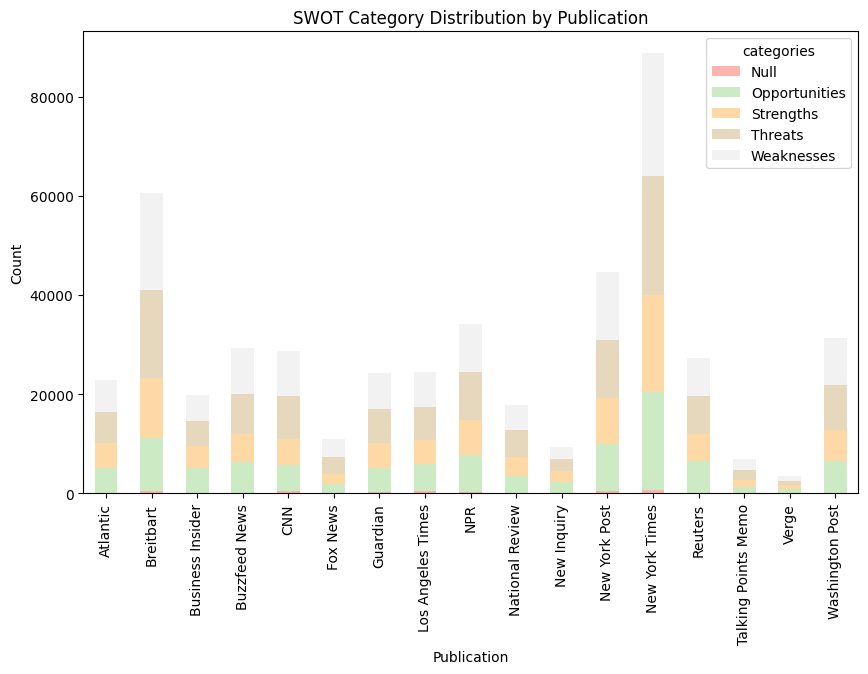

In [57]:
publication_swot = (
    df.explode('categories')
    .groupby(['publication', 'categories'])
    .size()
    .unstack(fill_value=0)
)

print(publication_swot)
publication_swot.plot(kind='bar', stacked=True, figsize=(10, 6), colormap="Pastel1")
plt.title("SWOT Category Distribution by Publication")
plt.ylabel("Count")
plt.xlabel("Publication")
plt.show()

In [58]:
df['company'] = df['content'].str.extract(r'(CompanyName|BrandName|...)')  # Adjust regex for specific companies

company_swot = (
    df.explode('categories')
    .groupby(['company', 'categories'])
    .size()
    .unstack(fill_value=0)
)

print(company_swot)

categories  Null  Opportunities  Strengths  Threats  Weaknesses
company                                                        
04             0              1          1        1           1
1 A            0              4          3        4           4
1 C            0              0          2        2           0
1 D            0              2          3        4           3
1 F            0              1          1        1           1
...          ...            ...        ...      ...         ...
âœI            0              0          0        1           1
âœM            0              1          1        1           1
âœS            0              0          0        1           1
âœT            0              2          2        2           2
Чит            0              0          0        1           0

[4240 rows x 5 columns]
